<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-ABS-provisional-mortality-data" data-toc-modified-id="Get-ABS-provisional-mortality-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get ABS provisional mortality data</a></span></li><li><span><a href="#Plot-provisional-mortality" data-toc-modified-id="Plot-provisional-mortality-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot provisional mortality</a></span><ul class="toc-item"><li><span><a href="#rough-estimate-of-Excess-deaths" data-toc-modified-id="rough-estimate-of-Excess-deaths-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>rough estimate of Excess deaths</a></span></li></ul></li><li><span><a href="#Get-Australian-COVID-deaths-data" data-toc-modified-id="Get-Australian-COVID-deaths-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Get Australian COVID deaths data</a></span></li><li><span><a href="#Group-Australian-COVID-data-by-week" data-toc-modified-id="Group-Australian-COVID-data-by-week-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Group Australian COVID data by week</a></span></li></ul></div>

## Python set-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
#pandas
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# scraping
import datetime
import requests
from bs4 import BeautifulSoup

In [3]:
# plotting stuff
plt.style.use('ggplot')
CHART_DIRECTORY = '../charts'
Path(CHART_DIRECTORY).mkdir(parents=True, exist_ok=True)
CHART_DIRECTORY += '/!ABS-Provisional-Mortality-'

## Get ABS provisional mortality data

In [4]:
# get the data
DIRECTORY = "../data/"
FILE = "provisional mortality statistics weekly dashboard jan-apr 2020.xls"
deaths = pd.read_excel(DIRECTORY + FILE, sheet_name="Table 1.1", header=5, index_col=0)
deaths.index.name = None
deaths = deaths.dropna(how='any', axis='columns', thresh=10)
deaths = deaths.dropna(how='all', axis='rows')
deaths = deaths[deaths.index.notna()]
deaths = deaths.T

In [5]:
deaths.columns

Index(['week ended', 'Total doctor certified deaths - 2020',
       'Total doctor certified deaths - 2015-19 average',
       'Total doctor certified deaths - 2015-19 minimum',
       'Total doctor certified deaths - 2015-19 maximum',
       'Respiratory diseases - 2020', 'Respiratory diseases - 2015-19 average',
       'Influenza and pneumonia - 2020',
       'Influenza and pneumonia - 2015-19 average',
       'Chronic lower respiratory conditions - 2020',
       'Chronic lower respiratory conditions - 2015-19 average',
       'Cancer - 2020', 'Cancer - 2015-19 average',
       'Ischaemic heart diseases - 2020',
       'Ischaemic heart diseases - 2015-19 average',
       'Cerebrovascular diseases - 2020',
       'Cerebrovascular disease - 2015-19 average',
       'Dementia including Alzheimers - 2020',
       'Dementia including Alzheimers - 2015-19 average', 'Diabetes - 2020',
       'Diabetes - 2015-19 average', '0-44', '45-64', '65-74', '75-84',
       '85 and over', 'All ages', '0

## Plot provisional mortality

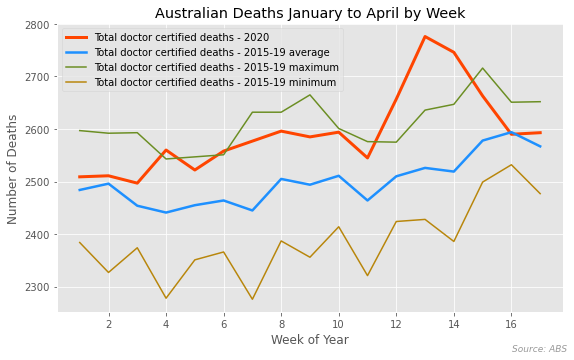

In [6]:
cols = ['Total doctor certified deaths - 2020',
        'Total doctor certified deaths - 2015-19 average',
        'Total doctor certified deaths - 2015-19 maximum',
        'Total doctor certified deaths - 2015-19 minimum',
       ]
linewidths = [3, 2.5, 1.5, 1.5]
colours = ['orangered', 'dodgerblue', 'olivedrab', 'darkgoldenrod']

fig, ax = plt.subplots()
for col, lw, c in zip(cols, linewidths, colours):
    deaths[col].plot(lw=lw, c=c, label=col, ax=ax)

    title = 'Australian Deaths January to April by Week'
ax.set_title(title)
ax.set_ylabel('Number of Deaths')
ax.set_xlabel('Week of Year')
ax.legend(loc='best')

fig = ax.figure
fig.set_size_inches(8, 5)
fig.text(0.99, 0.01, 'Source: ABS',
    ha='right', va='bottom',
    fontsize=9, fontstyle='italic',
    color='#999999')
fig.tight_layout(pad=1)

fig.savefig(f'{CHART_DIRECTORY}{title}.png', dpi=125)
plt.show()  
plt.close()

### rough estimate of Excess deaths
which does not account for population growth

In [7]:
excess = (deaths['Total doctor certified deaths - 2020'] - 
          deaths['Total doctor certified deaths - 2015-19 average'])

In [8]:
excess.index = deaths['week ended']

## Get Australian COVID deaths data

In [9]:
def scrape_wiki_data():
    
    # get cases
    url = 'https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/Australia_medical_cases'
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'lxml')
    tables = soup.findAll('table')
    for table in tables:
        if table.findParent("table") is None:
            cases = pd.read_html(table.prettify(), header=0, index_col=0)[0]
            break
            
    # get deaths
    url = 'https://en.wikipedia.org/wiki/Template:COVID-19 pandemic data/Australia deaths'
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'lxml')
    tables = soup.findAll('table')
    for table in tables:
        if table.findParent("table") is None:
            deaths = pd.read_html(table.prettify(), header=1, index_col=0)[0]
            break

    return cases, deaths

#cases, deaths = scrape_wiki_data()
#print(deaths)

In [10]:
def common_cleaning(df: pd.DataFrame, mode: str) -> pd.DataFrame:
    
    # 5. if the last row is today, 
    #    delete it as incomplete by definition
    now = datetime.datetime.today().date()
    yesterday = (pd.Timestamp((now - datetime.timedelta(days=1))
                           .strftime('%Y-%m-%d'))
                )
    today = now.strftime('%-d %B')
    year = now.strftime('%Y')
    if df.index[-1] == today:
        df = df.iloc[:-1]
    
    # 6. make numeric
    df = df.astype(float)

    # 7. make the index a DatetimeIndex
    #    expand to all days
    df.index = pd.DatetimeIndex(df.index + year, dayfirst=True).date
    idx = pd.date_range(df.index.min(), df.index.max())
    df = df.reindex(idx, fill_value=np.nan)
    df = df.where(df > 0, other=np.nan).ffill().fillna(0)#.astype(int)
    
    # reindex (to PeriodIndex)
    idx = pd.date_range(df.index.min(), yesterday)
    df = df.reindex(idx, fill_value=np.nan).ffill()
    
    # 8. make sure it is in date order
    df = df.sort_index()

    return df

In [11]:
def clean_wiki_cases(df):    
    # --- clean-up what we scraped - very tedious
    #     as this table is very messy - fragile
    #     as Wikipedia constantly changes its layout
    #     and format.

    # 1. get rid of footnotes from column names, etc.
    df.columns = (df.columns.str.replace('\[.*\]', '')
                  .str.replace('  ', ' ')
                  .str.strip())
    df.index = df.index.str.replace('\[.*\]', '')

    # 2. remove nan and other rows
    df = df[df.index.notna()]
    df = df[df.index.str.contains('[0-9]')] # not dates
    df = df[~df.index.str.contains('Values')]
    df = df[~df.index.str.contains('Notes')]


    # 3. remove footnotes from specified columns
    if 'Ref.' in df.columns:
        del df['Ref.']
    if 'Reference' in df.columns:
        del df['Reference']
    for c in df.columns:
        df[c] = (df[c].str.replace('\[.*\]', '').str.strip())
        df[c] = df[c].str.replace(',', '')

    # 4. remove '%' text from specified columns
    cols = ['% growth']
    for c in cols:
        df[c] = (df[c].str.replace('\%', '')
                 .str.strip().astype(float))

    df = common_cleaning(df, 'cases')
    
    return df

In [12]:
def clean_wiki_deaths(df):
    
    # 1. delete reference column
    if 'Ref.' in df.columns:
        del df['Ref.']
    if 'Reference' in df.columns:
        del df['Reference']
    
    # 2. remove nan and other rows
    df = df[df.index.notna()]
    df = df[df.index.str.contains('[0-9]')] # not dates

    df = common_cleaning(df, 'deaths')

    return df

In [13]:
def scrape_and_clean_data():
    cases, deaths = scrape_wiki_data()
    cases = clean_wiki_cases(cases)
    deaths = clean_wiki_deaths(deaths)
    
    return cases, deaths

In [14]:
_, covid = scrape_and_clean_data()

## Group Australian COVID data by week

In [15]:
deaths['week ended']

1    2020-01-07
2    2020-01-14
3    2020-01-21
4    2020-01-28
5    2020-02-04
6    2020-02-11
7    2020-02-18
8    2020-02-25
9    2020-03-03
10   2020-03-10
11   2020-03-17
12   2020-03-24
13   2020-03-31
14   2020-04-07
15   2020-04-14
16   2020-04-21
17   2020-04-28
Name: week ended, dtype: datetime64[ns]

In [16]:
type(deaths['week ended'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [17]:
type(covid.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [18]:
# get data - convert from cumulative to daily data
previous = covid.index[0] - pd.Timedelta(days=1)
covid = covid.Total
covid.T[previous] = 0.0
covid = covid.sort_index(ascending=True)
covid = covid.diff().dropna()

In [19]:
weekly_covid = covid.resample('W-TUE').sum() 
# week ending by default; Note: 2020 began on a Wednesday. 

In [20]:
weekly_covid = weekly_covid.reindex(weekly_covid.index.union(excess.index)).fillna(0)

In [21]:
range = (deaths['Total doctor certified deaths - 2015-19 maximum'] -
        deaths['Total doctor certified deaths - 2015-19 minimum']).mean()
σ = range / (3 * np.sqrt(np.log(5)) - 1.5)
upper = deaths['Total doctor certified deaths - 2015-19 average'] + 1.96 * σ
lower = deaths['Total doctor certified deaths - 2015-19 average'] - 1.96 * σ

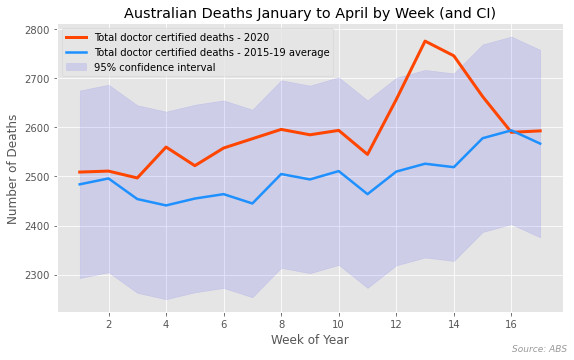

In [22]:
fig, ax = plt.subplots()
columns = ['Total doctor certified deaths - 2020',
           'Total doctor certified deaths - 2015-19 average',]
for col, lw, c in zip(columns, linewidths, colours):
    deaths[col].plot(lw=lw, c=c, label=col, ax=ax)

ax.fill_between(x=upper.index.to_list(), y1=lower.to_list(), 
                y2=upper.to_list(), color='blue', alpha=0.1,
                label='95% confidence interval')
    
title = 'Australian Deaths January to April by Week (and CI)'
ax.set_title(title)
ax.set_ylabel('Number of Deaths')
ax.set_xlabel('Week of Year')
ax.legend(loc='best')

fig = ax.figure
fig.set_size_inches(8, 5)
fig.text(0.99, 0.01, 'Source: ABS',
    ha='right', va='bottom',
    fontsize=9, fontstyle='italic',
    color='#999999')
fig.tight_layout(pad=1)

fig.savefig(f'{CHART_DIRECTORY}{title}.png', dpi=125)
plt.show()  
plt.close()